<a href="https://colab.research.google.com/github/nrenzan/Handwritten_Text_Recognization/blob/main/Finalmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwritten optical character recognition

---

Optical Character recognition (OCR) with RNN Encoder-Decoder model. <br>
This character recognition model was made with self made data and might perform better with cursive handwritting <br>
<br>
**Steps:**
 * Imports and setups
 * Data loading and preprocessing
 * CTC setup
 * Model setup and training
 * Evaluation and analysis

# Importing and setup
This step contains importing all needed libraries and defining hyperparameters and variables.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/DL/images.zip


unzip:  cannot find or open /content/drive/MyDrive/DL/images.zip, /content/drive/MyDrive/DL/images.zip.zip or /content/drive/MyDrive/DL/images.zip.ZIP.


In [3]:
# import all tensorflow related libraries
import tensorflow as tf
import tensorflow.data as tfd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# import other libraries
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as implt
from IPython.display import clear_output as cls

## Defining the necessary variables

In [4]:
IMG_WIDTH = 200
IMG_HEIGHT = 50
IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 8
EPOCHS = 150
LEARNING_RATE = 1e-3
MODEL_NAME = "CharacterRecognition-Model"
TRAIN_SIZE = BATCH_SIZE * 3000
VALID_SIZE = BATCH_SIZE * 1500
TEST_SIZE  = BATCH_SIZE * 300
AUTOTUNE = tfd.AUTOTUNE

# Training callbacks
CALLBACKS = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath=MODEL_NAME + ".h5", save_best_only=True)
]

# Paths
train_csv_path = '/content/train.csv'
valid_csv_path = '/content/valid.csv'
test_csv_path = '/content/test.csv'
train_image_dir = '/content/drive/MyDrive/DL/images-final/images/train'
valid_image_dir = '/content/drive/MyDrive/DL/images-final/images/validate'
test_image_dir = '/content/drive/MyDrive/DL/images-final/images/test'

# SetUp random seeds for numpy and TensorFlow
np.random.seed(2569)
tf.random.set_seed(2569)

# Data loading and Preprocessing
The datas are divided into 2 parts:
* Labels and File paths
* Images
<br>
There are some variables defined with `csv_path` at the end of their names. Those are the files that contain the **labels** and **file paths** for them. <br>
The images are stored in the paths where their variables are defined with the ending of `image_dir`.

---

First the `.csv` files are loaded. After that the labels and their file paths get extracted. After that, the labels are processed and the images are loaded based on the file names of the labels. At the end the images also get preprocessed to be ready for getting feeded to the model.

In [5]:
# load the csv files
train_csv = pd.read_csv(train_csv_path)[:TRAIN_SIZE]
test_csv = pd.read_csv(test_csv_path)[:TEST_SIZE]
valid_csv = pd.read_csv(valid_csv_path)[:VALID_SIZE]

In [6]:
train_csv.head()

,FILENAME,IDENTITY
0,Diethyl triptamin-2.png,Diethyl triptamin-2
1,Phenmetrazine-5.png,Phenmetrazine-5
2,Phenmetrazine-4.png,Phenmetrazine-4
3,Evogen-2.png,Evogen-2
4,Lycergic Acid Diethylamide-2.png,Lycergic Acid Diethylamide-2


### Load the train labels
The labels will target the images. They basically attach a class to each image. <br>
As mentioned before, the labels are in the `.csv` files in the column named `IDENTITY`. <br>

In [7]:
# get the train labels
train_labels = [str(word) for word in train_csv["IDENTITY"].to_numpy()]

In [8]:
# extract all the unique characters
unique_characters = set(char for word in train_labels for char in word)
# define the number of classes (for labels) based on the number of unique characters
n_classes = len(unique_characters)

In [9]:
print(f"Number of unique classes(unique characters): {n_classes}")

Number of unique classes(unique characters): 66


In [10]:
# get the maximum length that a label can have
MAX_LABEL_LENGTH = max(map(len, train_labels))

In [11]:
print(f"The length of the longest label in the datase: {MAX_LABEL_LENGTH}")

The length of the longest label in the datase: 49


### Load the images paths
In the `.csv` files, there paths for the images related to each label. However, there are only the names of the images. So, they have to preprocessed and the path of them must also be added to them. This step is crucial for loading images.

In [12]:
train_csv['FILENAME'] = [train_image_dir + f"/{filename}" for filename in train_csv['FILENAME']]
valid_csv['FILENAME'] = [valid_image_dir + f"/{filename}" for filename in valid_csv['FILENAME']]
test_csv['FILENAME']  = [test_image_dir + f"/{filename}" for filename in test_csv['FILENAME']]

In [13]:
train_csv.head()

,FILENAME,IDENTITY
0,/content/drive/MyDrive/DL/images-final/images/...,Diethyl triptamin-2
1,/content/drive/MyDrive/DL/images-final/images/...,Phenmetrazine-5
2,/content/drive/MyDrive/DL/images-final/images/...,Phenmetrazine-4
3,/content/drive/MyDrive/DL/images-final/images/...,Evogen-2
4,/content/drive/MyDrive/DL/images-final/images/...,Lycergic Acid Diethylamide-2


## Label preprocessing
2 Dictionaries must be created. One for mapping characters to numerical values and one for mapping numerical values to characters

In [14]:
# Char to Num
char_to_num = StringLookup(vocabulary=list(unique_characters), mask_token=None)
num_to_char = StringLookup(vocabulary = char_to_num.get_vocabulary(), mask_token = None, invert = True)

In [15]:
len(char_to_num.get_vocabulary())+1

68

## Image preprocessing
**To Function must be used for image preprocessing part:** <br>
The first function is `load_image`. This function loads the images and returns the image as an `numpy` array. <br>
The second function is used for both images and labels. It gets the data and returns the encoded versions of them.

In [16]:
def load_image(image_path):
    """
    This function gets the image path and
    reads the image using TensorFlow, Then the image will be decoded and
    will be converted to float data type. next resize and transpose will be applied to it.
    In the final step the image will be converted to a Numpy Array using tf.cast
    """
    # read the image
    image = tf.io.read_file(image_path)
    # decode the image
    decoded_image = tf.image.decode_jpeg(contents=image, channels=1)
    # convert image data type to float32
    convert_imgs = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize and transpose
    resized_image = tf.image.resize(images=convert_imgs, size=(IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm = [1, 0, 2])

    # to numpy array (Tensor)
    image_array = tf.cast(image, dtype=tf.float32)

    return image_array

In [17]:
def encode_single_sample(image_path, label:str):

    '''
    The function takes an image path and label as input and returns a dictionary containing the processed image tensor and the label tensor.
    First, it loads the image using the load_image function, which decodes and resizes the image to a specific size. Then it converts the given
    label string into a sequence of Unicode characters using the unicode_split function. Next, it uses the char_to_num layer to convert each
    character in the label to a numerical representation. It pads the numerical representation with a special class (n_classes)
    to ensure that all labels have the same length (MAX_LABEL_LENGTH). Finally, it returns a dictionary containing the processed image tensor
    and the label tensor.

    '''

    # Get the image
    image = load_image(image_path)
    # Convert the label into characters
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')
    # Convert the characters into vectors
    vecs = char_to_num(chars)

    # Pad label
    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs}

In [18]:
# Training Data
train_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(train_csv['FILENAME'].to_list()), np.array(train_csv['IDENTITY'].to_list()))
).shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Validation data
valid_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(valid_csv['FILENAME'].to_list()), np.array(valid_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Testing data.
test_ds = tf.data.Dataset.from_tensor_slices(
    (np.array(test_csv['FILENAME'].to_list()), np.array(test_csv['IDENTITY'].to_list()))
).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [19]:
# check the data distribution
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 2176
Validation Data Size : 200
Testing Data Size    : 480


### Explore the dataset
See some images

In [20]:
def show_images(data, GRID=[4,4], FIGSIZE=(25, 8), cmap='binary_r', model=None, decode_pred=None):

    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_rows, n_cols = GRID

    # Loading Data
    data = next(iter(data))
    images, labels = data['image'], data['label']

    # Iterate over the data
    for index, (image, label) in enumerate(zip(images, labels)):

        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        plt.axis('off')

        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

In [21]:
# train=pd.read_csv("/content/train.csv")

In [22]:
# train.head()

In [23]:
# train.shape

In [24]:
# for i in range(1,5):
  # df = train[~train['FILENAME'].str.contains(f'Hermons _–-{i}.png')]


In [25]:
# df.shape

In [26]:
# df.sum()

# Neural Net Model and Training
The data has been readeed and preprocessed and everything is *go* for model training. <br>

---

**There are 4 main sections in the model training part:**
* CTC Loss (more explaination in its dedicated section)
* Model Creation
* Training
* Testing and evaluation

## CTC Loss
---
### Short Explaination:
**The *Connectionist Temporal Classification*(CTC) loss is used for seq2seq tasks.** <br>
In this case, the **CTC Loss** will take the ***Predicted Sequence of Characters*** and the ***label*** and calculates how far are they from each other. <br>
The **other task** of CTC is to align the the length of predicted sequence and the label by addin blank spaces.

---
### Implementation:
A class named `CTCLayer` is going to be defined. The input length and the predicted length are going to be taken. Then the loss

In [27]:
class CTCLayer(Layer):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        # define the loss function
        self.loss_function = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_hat):
        # Get the batch length
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")

        # get the input and label lengths
        input_len = tf.cast(tf.shape(y_hat)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        # calculate the loss
        loss = self.loss_function(y_true, y_hat, input_len, label_len)

        self.add_loss(loss)

        return y_hat

## Model Creation
The model used is a Encoder-Decoder Model which means it is a combinatio of CNN and RNN. <br>

---

#### Model Architecture:
The model has 2 Convolutional layers followed by MaxPools. <br>
The encoding space has one Dense layer. The Decoder network is consist of 2 Bidirectional LSTM layers.

In [28]:
# # Input Layer
# input_images = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# # Labels : These are added for the training purpose.
# input_labels = Input(shape=(None, ), name="label")

# ### Convolutional layers
# # layer 1
# conv_1 = Conv2D(64, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_1")(input_images)
# # layer 2
# conv_2 = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_2")(conv_1)
# max_pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_2)
# # layer 3
# conv_3 = Conv2D(64, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_3")(max_pool_1)
# conv_4 = Conv2D(32, 3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal', name="conv_4")(conv_3)
# max_pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_4)



# ### Encoding
# reshape = Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*32), name="reshape_layer")(max_pool_2)
# dense_encoding = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense")(reshape)
# dense_encoding_2 = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense_2")(dense_encoding)
# dropout = Dropout(0.4)(dense_encoding_2)

# # Decoder
# lstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name="bidirectional_lstm_1")(dropout)
# lstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name="bidirectional_lstm_2")(lstm_1)

# # Final Output layer
# output = Dense(len(char_to_num.get_vocabulary())+1, activation="softmax", name="output_dense")(lstm_2)

# # Add the CTC loss
# ctc_loss_layer = CTCLayer()(input_labels, output)

# # Define the final model
# model = Model(inputs=[input_images, input_labels], outputs=[ctc_loss_layer])
# model.summary()

# Input Layer
input_images = Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

# Labels : These are added for the training purpose.
input_labels = Input(shape=(None, ), name="label")

### Convolutional layers
# layer 1
conv_1 = Conv2D(64, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_1")(input_images)
max_pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_1)

# layer 2
conv_2 = Conv2D(32, 3, strides=1, padding="same", kernel_initializer="he_normal", activation="relu", name="conv_2")(max_pool_1)

### Encoding
reshape = Reshape(target_shape=((IMG_WIDTH//2), (IMG_HEIGHT//2)*32), name="reshape_layer")(conv_2)
dense_encoding = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense")(reshape)
dense_encoding_2 = Dense(64, kernel_initializer="he_normal", activation="relu", name="enconding_dense_2")(dense_encoding)
dropout = Dropout(0.4)(dense_encoding_2)

# Decoder
lstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25), name="bidirectional_lstm_1")(dropout)
lstm_2 = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25), name="bidirectional_lstm_2")(lstm_1)

# Final Output layer
output = Dense(len(char_to_num.get_vocabulary())+1, activation="softmax", name="output_dense")(lstm_2)

# Add the CTC loss
ctc_loss_layer = CTCLayer()(input_labels, output)

# Define the final model
model = Model(inputs=[input_images, input_labels], outputs=[ctc_loss_layer])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 200, 50, 64)          640       ['image[0][0]']               
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 100, 25, 64)          0         ['conv_1[0][0]']              
 D)                                                                                               
                                                                                                  
 conv_2 (Conv2D)             (None, 100, 25, 32)          18464     ['max_pooling2d[0][0]']   

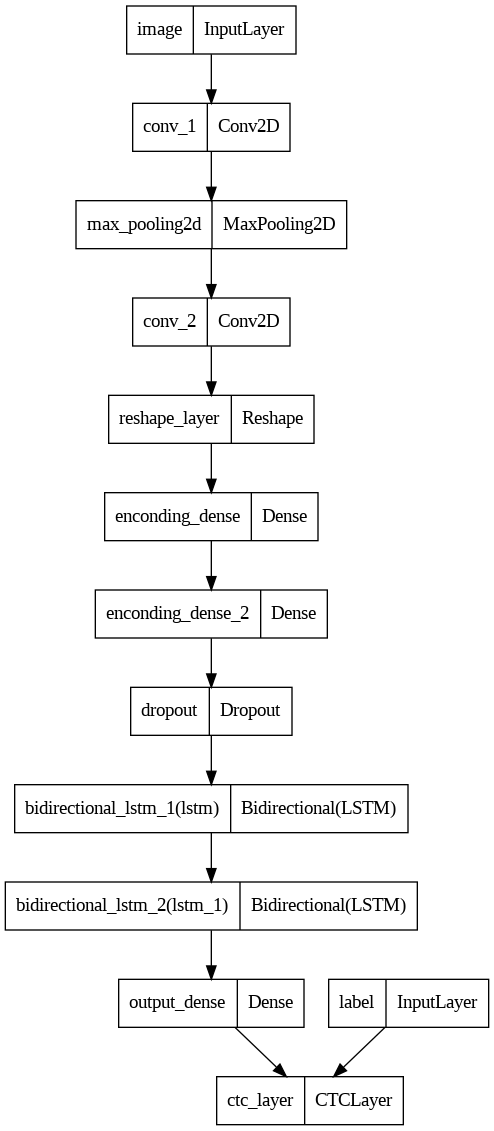

In [29]:
# draw the model plot
tf.keras.utils.plot_model(
    model,
    to_file='model-graph.png'
)

### Model Training

In [30]:
# compile the model
model.compile(optimizer="adam")

In [32]:
# train the model
history = model.fit(train_ds, validation_data=valid_ds, epochs=EPOCHS, callbacks=CALLBACKS)

Epoch 1/150
272/272 [==============================] - 377s 1s/step - loss: 59.4182 - val_loss: 47.9590


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/150
272/272 [==============================] - 124s 454ms/step - loss: 47.7023 - val_loss: 46.0910
Epoch 3/150
272/272 [==============================] - 128s 471ms/step - loss: 46.8175 - val_loss: 45.8085
Epoch 4/150
272/272 [==============================] - 129s 473ms/step - loss: 46.4236 - val_loss: 45.4412
Epoch 5/150
272/272 [==============================] - 171s 630ms/step - loss: 46.2189 - val_loss: 45.2904
Epoch 6/150
272/272 [==============================] - 136s 498ms/step - loss: 45.8748 - val_loss: 44.9061
Epoch 7/150
272/272 [==============================] - 125s 457ms/step - loss: 44.6814 - val_loss: 43.5933
Epoch 8/150
272/272 [==============================] - 143s 527ms/step - loss: 43.5112 - val_loss: 42.7962
Epoch 9/150
272/272 [==============================] - 141s 516ms/step - loss: 42.4993 - val_loss: 41.9576
Epoch 10/150
272/272 [==============================] - 131s 480ms/step - loss: 41.6177 - val_loss: 41.0364
Epoch 11/150
272/272 [==============

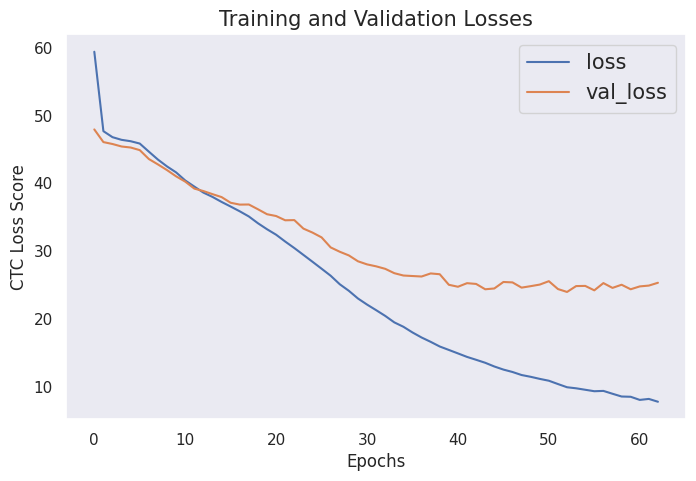

In [33]:
import seaborn as sb
# draw plot for results
sb.set()
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Training and Validation Losses", fontsize=15)
plt.grid()
plt.savefig("model_result.png")
plt.show()

## Testing and Evaluation

In [ ]:
# evaluate the model on the test dataset
evaluation = model.evaluate(test_ds)
print(f"evaluation loss: {evaluation}")

In [35]:
def decoder_prediction(pred_label):
    """
    This function has the job to decode the prediction that the model had.
    The model predicts each character and then this function makes it readable.
    """
    # Input length
    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

    # CTC decode
    decode = tf.keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=True)[0][0][:,:MAX_LABEL_LENGTH]

    # Converting numerics back to their character values
    chars = num_to_char(decode)

    # Join all the characters
    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

    # Remove the unknown token
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

In [ ]:
# define a model for testing and evaluation
pred_model = Model(inputs=model.get_layer(name="image").input, outputs=model.get_layer(name='output_dense').output)

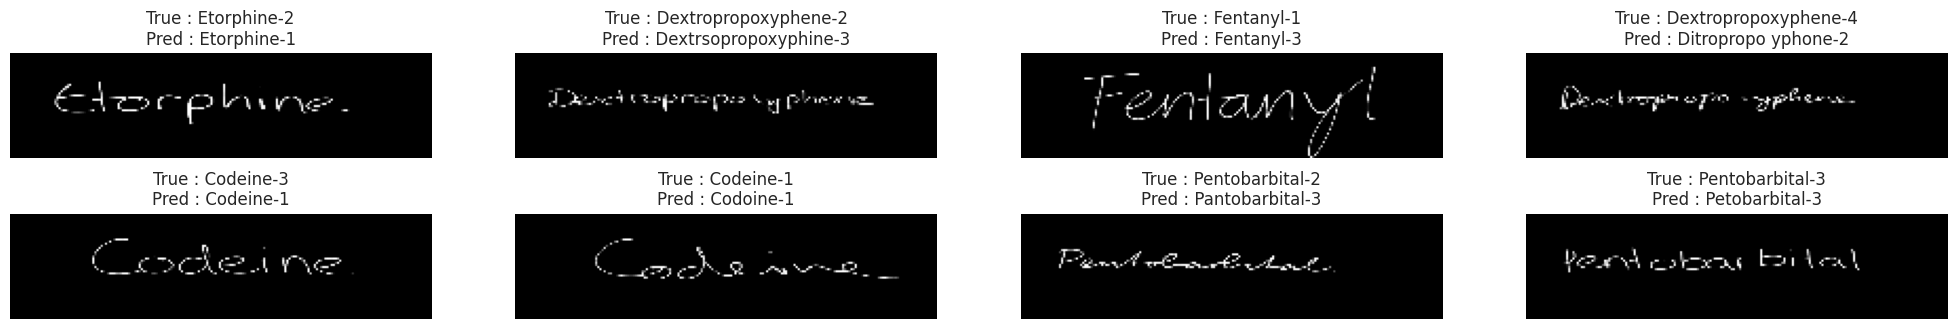

In [37]:
show_images(data=test_ds, model=pred_model, decode_pred=decoder_prediction, cmap='binary')

### Single Sample prediction

In [38]:
def single_sample_prediction(model, path):
    """
    This function gets an image path and the model,
    Loads and preprocesses the image and make predictions on it.
    """
    # load image
    image_loading = tf.io.read_file(path)
    # decode image
    decoded_image = tf.image.decode_jpeg(contents=image_loading, channels=1)
    # convert the image data type to float
    convert_image = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    # resize the image
    resized_image = tf.image.resize(images=convert_image, size=(IMG_HEIGHT, IMG_WIDTH))
    resized_image = tf.transpose(resized_image, perm = [1, 0, 2])
    # convert image to array
    image_array = tf.cast(resized_image, dtype=tf.float32)
    # reshape image
    single_image_data_with_batch = np.expand_dims(image_array, axis=0)

    # make prediction
    prediction = decoder_prediction(model.predict(single_image_data_with_batch))

    return prediction

1/1 [==============================] - 0s 116ms/step
['(a) Oxytetracycilline-3']


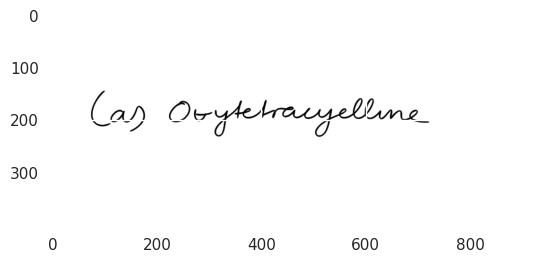

In [48]:
# prediction 1:
img_1_path = "/content/drive/MyDrive/DL/images-final/images/test/(a) Oxytetracyclline-2.png"
img_1 = implt.imread(img_1_path)
plt.imshow(img_1)
print(single_sample_prediction(pred_model, img_1_path))


1/1 [==============================] - 0s 65ms/step
['6 – Mercaptopurine-1']


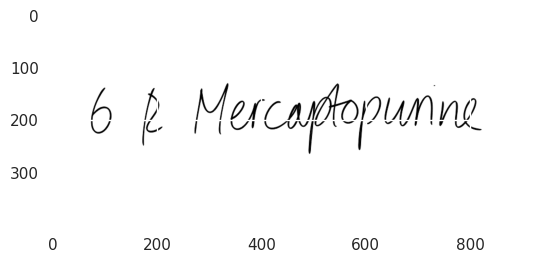

In [46]:
# prediction 2:
img_2_path = "/content/drive/MyDrive/DL/images-final/images/test/6 – Mercaptopurine-1.png"
img_2 = implt.imread(img_2_path)
plt.imshow(img_2)
print(single_sample_prediction(pred_model, img_2_path))

1/1 [==============================] - 0s 185ms/step
['Dextrorophan-3']


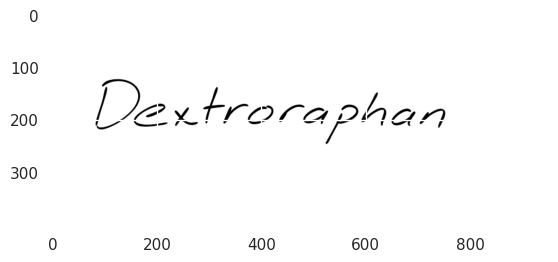

In [44]:
# prediction 3:
img_3_path = "/content/drive/MyDrive/DL/images-final/images/test/Dextroraphan-2.png"
img_3 = implt.imread(img_3_path)
plt.imshow(img_3)
print(single_sample_prediction(pred_model, img_3_path))

### Saving the model

In [43]:
# save the model
model.save("model.hd5")
# save weights
model.save_weights("model_weights.hd5")